In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import time
import os
from tbats import TBATS
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Adjust the options for viewing charts in notebook
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

# Adjust options for viewing dataframes in notebook
pd.set_option('display.width', 2000)

In [2]:
# Function for reading a data file
def read_data(name):
    df = pd.read_csv('./../../data/clean_data/' + name + '.csv')
    df['Hour'] = pd.to_datetime(df['Hour'])
    df = df.set_index('Hour')
    df.index.freq = 'h'
    return df

In [3]:
# Function for plotting training, predicted and actual values
def plot(train, predictions, actual):
    plt.plot(predictions, label='Forecast', color='blue')
    plt.plot(train, label='Train', color='orange')
    plt.plot(actual, label='Actual', color='red')
    plt.title('Forecast vs Actuals')
    plt.ylabel('Energy Consumption')
    plt.legend(loc='upper left', fontsize=8)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [4]:
# Function for forecasting using TBATS
def predict_TBATS(train, test_steps):
    # Seasonal periods are 24 and 168 (24 hours make up a day and 168 hours make up a week)
    estimator = TBATS(seasonal_periods=(24, 168))

    # Fit the model to the training data
    fitted_model = estimator.fit(train)

    # Forecast ahead
    forecast = fitted_model.forecast(steps=test_steps)

    # Prevent negative demand values
    forecast[forecast < 0] = 0
    return forecast


In [5]:
# Function for locating random batches from dataset

## Take dataset, length of training data, length of testing data and number of batches to extract as parameters
## Find a number of digits that represent the indices of the original dataset, where the extracted batches will start from
## Each subset dataset will not intersect with other datasets
def extract_batches(df, train_length, test_length, batch_count):
    start = time.time()
    random_int_list = []
    m = 0
    random.seed(1)
    data_end = len(df)
    new_data_size = train_length + test_length
    while m < batch_count:
        random_int = random.randint(0, data_end - new_data_size)
        q = 0
        for i in random_int_list:
            # Make sure batches do not overlap
            if i + new_data_size <= random_int or random_int + new_data_size <= i:
                pass
            else:
                q = 1
                # In case solution does not exist with current combination
                if time.time() - start > 2:
                    print('Restarted')
                    random_int_list = []
                    start = time.time()
                    m = 0

        # Prevent batches with 0 energy
        if df['Energy'][random_int: random_int + train_length].sum() == 0:
            q = 1
        elif df['Energy'][random_int +  train_length: random_int + new_data_size].sum() == 0:
            q = 1

        # Record the position of the batch
        if q == 0:
            random_int_list.append(random_int)
            m = m + 1
    return random_int_list

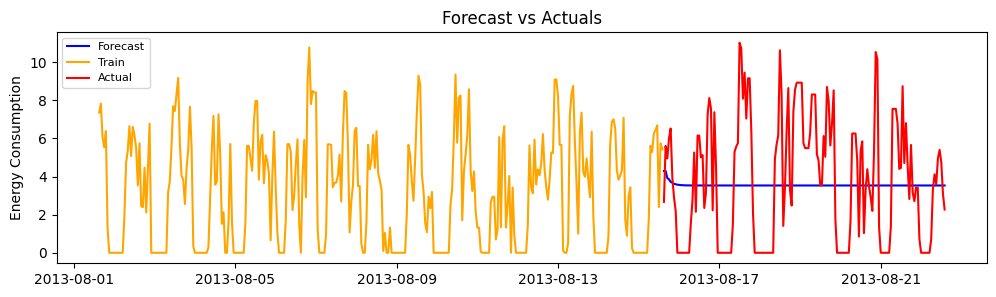

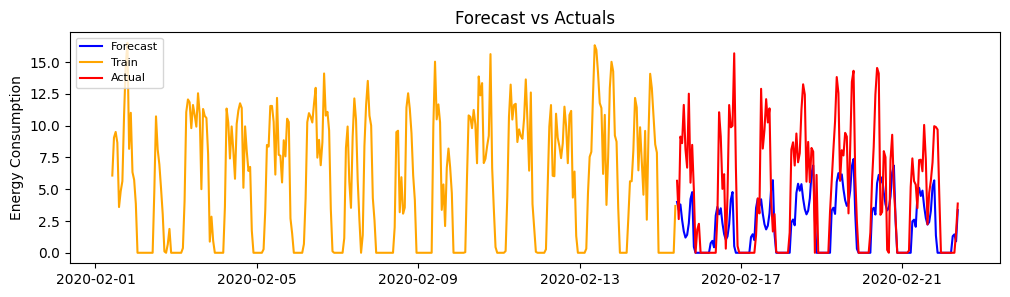

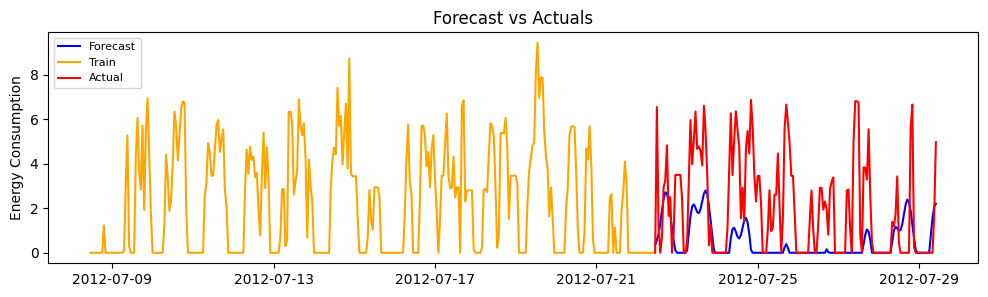

,Batch 1,Batch 2,Batch 3,Average
NRMSE,0.854,0.917,1.248,1.006
NMAE,0.743,0.619,0.863,0.742


In [6]:
# Testing TBATS on HAMILTON.txt with 3 random batches and plotting
df = read_data('HAMILTON')
train_length = 336  # 14 days
test_length = 168   # 7 days
start_index_list = extract_batches(df, train_length, test_length, 3)

# Create an empty results dataframe to hold the results
row_headers = ['NRMSE', 'NMAE']
df_results = pd.DataFrame()

for start_index in start_index_list:
    # Creating series for train, test, and predictions
    train = df[start_index: start_index + train_length]['Energy']
    test = df[start_index + train_length: start_index + train_length + test_length]['Energy']
    predictions = pd.Series(predict_TBATS(train, test_length), index=test.index)

    # Normalised Root Mean Square Error
    nrmse_value = np.round(sqrt(mean_squared_error(test, predictions)) / test.mean(), 3)
    # Normalised Mean Absolute Error
    nmae_value = np.round(mean_absolute_error(test, predictions) / test.mean(), 3)

    # Append the batch results to the results dataframe
    row = [nrmse_value, nmae_value]
    df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    plot(train, predictions, test) 

# Calculate the average of each column
average_value_list = np.round(df_results.mean(), 3).tolist()

# Append the average to each column
df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)

# Reformat the results dataframe
df_results = df_results.transpose()
df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Average']

# Display results
display(df_results)

In [7]:
# Function for running the accuracy tests and collecting the results
def analyse(df, train_length, test_length, batch_count):
    # Find appropriate (random) indices for batches to prevent overlap
    start_index_list = extract_batches(df, train_length, test_length, batch_count)

    # Create the empty results dataframe to hold the results
    row_headers = ['Energy (kWh)', 'NRMSE', 'NMAE']
    df_results = pd.DataFrame()

    # For each batch, get testing and training data and make predictions
    for start_index in start_index_list:
        # Creating series for train, test, and predictions
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]
        predictions = predict_TBATS(train['Energy'], test_length)

        # Calculate total energy demand in batch
        demand_value = np.round(test['Energy'].sum(), 3)

        # Prevent dividing by zero
        if test['Energy'].mean() != 0:
            test_mean = test['Energy'].mean()
        else:
            test_mean = 1

        # Calculate accuracy metrics for each batch:
        ## Record Normalised Root Mean Square Error of batch
        nrmse_value = np.round(sqrt(mean_squared_error(test['Energy'], predictions))/test_mean, 3)
        ## Record Normalised Mean Absolute Error of batch
        nmae_value = np.round(mean_absolute_error(test['Energy'], predictions)/test_mean, 3)

        # Append the batch results to the results dataframe
        row = [demand_value, nrmse_value, nmae_value]
        df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    # Calculate the average of each column
    average_value_list = np.round(df_results.mean(), 3).tolist()
    # Calculate the minimum of each column
    min_value_list = np.round(df_results.min(), 3).tolist()
    # Calculate the maximum of each column
    max_value_list = np.round(df_results.max(), 3).tolist()
    # Calculate the standard deviation of each column
    stddev_value_list = np.round(df_results.std(), 3).tolist()
 
    # Append the average to each column
    df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)
    # Append the minimum to each column
    df_results = pd.concat([df_results, pd.DataFrame([min_value_list], columns=row_headers)], ignore_index=True)
    # Append the maximum to each column
    df_results = pd.concat([df_results, pd.DataFrame([max_value_list], columns=row_headers)], ignore_index=True)
    # Append the standard deviation to each column
    df_results = pd.concat([df_results, pd.DataFrame([stddev_value_list], columns=row_headers)], ignore_index=True)

    # Reformat the results dataframe
    df_results = df_results.transpose()
    df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5', 'Batch 6', 'Batch 7', 'Batch 8', 'Batch 9', 'Batch 10',
                            'Average', 'Minimum', 'Maximum', 'Std. Dev.']
    
    # Display results
    display(df_results)

    return df_results


In [8]:
# Conducting extensive batch testing of accuracy metrics on different forecast periods and training period lengths, with 10 random batches each
def main(name):
    # Make the directory for the results
    if os.path.isdir('../../data/accuracy_results/TBATS'):
        pass
    else:
        os.makedirs('../../data/accuracy_results/TBATS')

    print('-- Performance metric testing --')
    df = read_data(name)
    print('\n{}'.format(name))
    file_name = '../../data/accuracy_results/TBATS/' + name + '_TBATS.xlsx'

    # Write the tables to appropriate xlsx files
    with pd.ExcelWriter(file_name, mode='w', engine='xlsxwriter') as writer:

        # Run the tests for each training type
        q = 0
        while q < 3:
            # Modify execution parameters if needed
            test_length = [336, 168, 72, 24]                               # Hours in testing set
            batch_count = [10, 10, 10, 10]                                 # Batch count
            start_row = [1, 6, 11, 16]                                     # Row position in xlsx file to write results in
            durations = ['14 Days', '7 Days', '3 Days', '1 Day']           # Durations of batches, used for titles

            if q == 0:
                # 1. Two weeks training data
                print('-- Two Weeks Training Data --')
                pd.DataFrame(['14 Days Training']).to_excel(writer, sheet_name=name, startrow=0, header=None, index=None)

                train_length = [336, 336, 336, 336]                        # Hours in training set
                start_col = 0                                              # Column position in xlsx file to write results in
            elif q == 1:
                # 2. 75:25 Ratio of training to testing data
                print('-- 75:25 Ratio of Training to Testing Data --')
                pd.DataFrame(['Training:Testing = 75:25']).to_excel(writer, sheet_name=name, startrow=0, startcol=16, header=None, index=None)

                train_length = [1008, 504, 216, 72]                        # Hours in training set
                start_col = 16                                             # Column position in xlsx file to write results in
            else:
                # 3. 50:50 Ratio of training to testing data
                print('-- 50:50 Ratio of Training to Testing Data --')
                pd.DataFrame(['Training:Testing = 50:50']).to_excel(writer, sheet_name=name, startrow=0, startcol=32, header=None, index=None)

                train_length = [336, 168, 72, 24]                          # Hours in training set
                start_col = 32                                             # Column position in xlsx file to write results in

            all_results_list = []

            i = 0
            while i < len(test_length):
                print('{} Ahead Forecast:'.format(durations[i]))

                # Run set of batches and collect results
                df_results = analyse(df, train_length[i], test_length[i], batch_count[i])
                all_results_list.append(df_results)

                # Write results to xlsx file
                df_results.to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                pd.DataFrame(['{} Forecast'.format(durations[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                i = i + 1

            # Create summary dataframes
            df_summary_avg = pd.concat([df['Average'] for df in all_results_list], axis="columns")
            df_summary_min = pd.concat([df['Minimum'] for df in all_results_list], axis="columns")
            df_summary_max = pd.concat([df['Maximum'] for df in all_results_list], axis="columns")
            df_summary_stddev = pd.concat([df['Std. Dev.'] for df in all_results_list], axis="columns")

            for i in [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]:
                i.columns = durations

            # Modify summary parameters if needed
            start_row = [21, 26, 31, 36]                                                        # Row position in xlsx file to write results in
            summary_name = [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]  # Summary reference list
            print_title = ['Average', 'Minimum', 'Maximum', 'Standard Deviation']               # Title for printing results
            summary_title = ['Avg.', 'Min.', 'Max.', 'Std.Dev.']                                # Dataframe title in xlsx file

            i = 0
            while i < 4:
                print('{} Values Summary - {}:'.format(print_title[i], name))

                # Display summary
                display(summary_name[i])

                # Write summary to xlsx file
                summary_name[i].to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                pd.DataFrame(['{} Forecast'.format(summary_title[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                i = i + 1

            q = q + 1

        # Adjust the columns' widths
        worksheet = writer.sheets[name]
        workbook = writer.book
        worksheet.set_column(0, 0, 15)
        worksheet.set_column(16, 16, 20)
        worksheet.set_column(32, 32, 20)
        # Adjust cell formating
        format1 = workbook.add_format({'bg_color': '#EDEDED', 'border': 1})
        worksheet.conditional_format(0, 0, 39, 46, {'type': 'no_blanks', 'format': format1})


In [10]:
main('WEBSTER')

-- Performance metric testing --

WEBSTER
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.190,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
NRMSE,0.701,0.885,0.912,0.736,0.433,0.841,0.447,1.371,1.743,0.957,0.903,0.433,1.743,0.399
NMAE,0.549,0.694,0.748,0.501,0.332,0.570,0.363,0.873,1.163,0.821,0.661,0.332,1.163,0.253


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1642.875,1378.006,1231.265,1109.232,1947.639,1272.497,1947.678,1027.345,179.855,1343.281,1307.967,179.855,1947.678,509.329
NRMSE,0.690,0.877,0.867,0.714,0.442,0.824,0.448,1.256,2.957,0.607,0.968,0.442,2.957,0.738
NMAE,0.546,0.677,0.726,0.483,0.336,0.535,0.363,0.769,2.008,0.416,0.686,0.336,2.008,0.488


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),674.331,689.480,574.627,548.452,825.515,593.708,839.197,570.248,62.273,737.272,611.510,62.273,839.197,219.215
NRMSE,0.682,0.689,0.858,0.554,0.463,0.712,0.504,1.058,5.122,0.534,1.118,0.463,5.122,1.418
NMAE,0.552,0.554,0.749,0.352,0.355,0.467,0.412,0.674,4.092,0.388,0.860,0.352,4.092,1.144


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),229.586,163.234,271.363,245.623,111.703,179.943,227.082,167.094,6.218,255.276,185.712,6.218,271.363,80.265
NRMSE,0.520,0.714,0.543,0.628,1.215,0.380,0.563,0.513,14.393,0.558,2.003,0.380,14.393,4.359
NMAE,0.453,0.456,0.495,0.437,0.895,0.265,0.484,0.363,11.376,0.438,1.566,0.265,11.376,3.451


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1307.967,611.510,185.712
NRMSE,0.903,0.968,1.118,2.003
NMAE,0.661,0.686,0.860,1.566


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,179.855,62.273,6.218
NRMSE,0.433,0.442,0.463,0.380
NMAE,0.332,0.336,0.352,0.265


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,1947.678,839.197,271.363
NRMSE,1.743,2.957,5.122,14.393
NMAE,1.163,2.008,4.092,11.376


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,509.329,219.215,80.265
NRMSE,0.399,0.738,1.418,4.359
NMAE,0.253,0.488,1.144,3.451


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),512.484,2623.430,2453.461,2014.774,4238.914,2384.657,1061.268,2041.756,745.308,3793.892,2186.994,512.484,4238.914,1215.342
NRMSE,5.131,0.670,0.675,0.809,0.388,0.615,1.168,0.654,1.331,0.459,1.190,0.388,5.131,1.415
NMAE,3.954,0.547,0.460,0.585,0.310,0.414,0.808,0.533,0.871,0.366,0.885,0.310,3.954,1.093


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1682.311,1232.184,1202.892,1047.740,2022.188,1408.102,1965.443,1121.042,442.457,961.306,1308.566,442.457,2022.188,480.887
NRMSE,0.572,0.751,1.539,0.710,0.459,0.657,0.471,0.729,1.232,0.930,0.805,0.459,1.539,0.343
NMAE,0.447,0.605,1.358,0.469,0.341,0.475,0.367,0.499,0.743,0.805,0.611,0.341,1.358,0.303


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),782.450,555.498,505.135,631.427,951.196,391.551,942.332,445.810,126.156,484.981,581.654,126.156,951.196,255.474
NRMSE,0.650,0.679,2.610,0.761,0.313,0.849,0.585,0.945,1.756,0.697,0.984,0.313,2.610,0.684
NMAE,0.556,0.525,2.289,0.570,0.237,0.642,0.502,0.701,0.932,0.514,0.747,0.237,2.289,0.569


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),296.216,60.465,172.158,147.807,277.709,82.775,310.803,103.316,8.336,255.917,171.550,8.336,310.803,108.218
NRMSE,0.717,4.513,161.077,1.524,14075.079,1.497,1.201,3131.348,776251.638,0.755,79362.935,0.717,776251.638,244901.293
NMAE,0.609,4.365,114.650,1.000,8265.995,0.869,1.000,1993.873,421813.106,0.527,43219.599,0.527,421813.106,133049.395


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2186.994,1308.566,581.654,171.550
NRMSE,1.190,0.805,0.984,79362.935
NMAE,0.885,0.611,0.747,43219.599


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),512.484,442.457,126.156,8.336
NRMSE,0.388,0.459,0.313,0.717
NMAE,0.310,0.341,0.237,0.527


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4238.914,2022.188,951.196,310.803
NRMSE,5.131,1.539,2.610,776251.638
NMAE,3.954,1.358,2.289,421813.106


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1215.342,480.887,255.474,108.218
NRMSE,1.415,0.343,0.684,244901.293
NMAE,1.093,0.303,0.569,133049.395


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.190,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
NRMSE,0.701,0.885,0.912,0.736,0.433,0.841,0.447,1.371,1.743,0.957,0.903,0.433,1.743,0.399
NMAE,0.549,0.694,0.748,0.501,0.332,0.570,0.363,0.873,1.163,0.821,0.661,0.332,1.163,0.253


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1620.515,1218.634,1444.036,1071.478,1985.305,945.207,2026.609,1192.549,401.147,1137.343,1304.282,401.147,2026.609,488.940
NRMSE,1.361,1.183,0.723,0.951,0.411,0.932,0.667,0.796,1.440,0.777,0.924,0.411,1.440,0.322
NMAE,1.000,1.028,0.566,0.729,0.313,0.655,0.569,0.548,0.813,0.548,0.677,0.313,1.028,0.221


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),854.792,257.110,525.899,505.714,845.222,341.503,1022.777,455.865,4.445000e+01,474.455,532.779,44.450,1.022777e+03,2.986180e+02
NRMSE,0.779,2.869,593.495,1.436,158135.245,1.636,1.199,14775.742,3.549432e+07,1.034,3566783.267,0.779,3.549432e+07,1.121830e+07
NMAE,0.636,2.699,494.637,1.000,119807.316,0.968,1.000,11690.820,2.409701e+07,0.709,2422900.782,0.636,2.409701e+07,7.615597e+06


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),58.975,100.873,206.136,228.316,342.823,163.299,179.004,202.791,85.068,212.942,178.023,58.975,342.823,82.526
NRMSE,1.942,2.922,0.529,0.905,0.804,0.894,0.878,1.405,2.454,0.830,1.356,0.529,2.922,0.811
NMAE,1.113,2.646,0.403,0.653,0.715,0.626,0.720,0.990,1.596,0.582,1.004,0.403,2.646,0.669


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1304.282,532.779,178.023
NRMSE,0.903,0.924,3566783.267,1.356
NMAE,0.661,0.677,2422900.782,1.004


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,401.147,44.450,58.975
NRMSE,0.433,0.411,0.779,0.529
NMAE,0.332,0.313,0.636,0.403


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,2026.609,1.022777e+03,342.823
NRMSE,1.743,1.440,3.549432e+07,2.922
NMAE,1.163,1.028,2.409701e+07,2.646


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,488.940,2.986180e+02,82.526
NRMSE,0.399,0.322,1.121830e+07,0.811
NMAE,0.253,0.221,7.615597e+06,0.669


In [20]:
main('CAMBRIDGE')

-- Performance metric testing --

CAMBRIDGE
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
NRMSE,0.785,1.006,0.854,0.895,0.495,0.976,0.689,0.962,1.293,1.114,0.907,0.495,1.293,0.222
NMAE,0.558,0.652,0.544,0.585,0.371,0.664,0.553,0.734,1.021,0.724,0.641,0.371,1.021,0.170


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1444.492,1369.866,928.969,900.689,984.465,1368.427,970.418,633.994,606.399,776.700,998.442,606.399,1444.492,302.739
NRMSE,0.934,1.001,0.767,0.897,0.459,0.978,0.712,1.066,1.233,0.999,0.905,0.459,1.233,0.214
NMAE,0.662,0.644,0.485,0.604,0.348,0.684,0.576,0.819,0.932,0.609,0.636,0.348,0.932,0.162


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),358.073,650.140,419.428,466.132,402.897,709.202,353.539,359.670,223.540,429.462,437.208,223.540,709.202,144.006
NRMSE,1.799,0.890,0.697,0.828,0.423,0.894,0.760,0.589,0.872,0.896,0.865,0.423,1.799,0.363
NMAE,1.261,0.611,0.433,0.566,0.320,0.662,0.611,0.419,0.676,0.556,0.611,0.320,1.261,0.256


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.485,216.404,162.154,175.727,113.535,193.151,80.726,132.508,65.550,112.353,137.759,65.550,216.404,48.497
NRMSE,1.072,0.742,0.672,0.698,0.667,0.717,1.006,0.485,0.876,0.840,0.778,0.485,1.072,0.174
NMAE,0.683,0.558,0.456,0.510,0.500,0.480,0.782,0.307,0.731,0.584,0.559,0.307,0.782,0.142


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,998.442,437.208,137.759
NRMSE,0.907,0.905,0.865,0.778
NMAE,0.641,0.636,0.611,0.559


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,606.399,223.540,65.550
NRMSE,0.495,0.459,0.423,0.485
NMAE,0.371,0.348,0.320,0.307


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1444.492,709.202,216.404
NRMSE,1.293,1.233,1.799,1.072
NMAE,1.021,0.932,1.261,0.782


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,302.739,144.006,48.497
NRMSE,0.222,0.214,0.363,0.174
NMAE,0.170,0.162,0.256,0.142


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.751,2033.177,1851.882,2289.041,1817.842,1349.984,1387.975,1342.536,1569.538,3212.624,1746.935,614.751,3212.624,691.486
NRMSE,6.062,0.902,1.009,0.774,0.470,0.686,0.943,0.978,0.492,0.661,1.298,0.470,6.062,1.685
NMAE,4.116,0.674,0.746,0.553,0.359,0.464,0.698,0.625,0.365,0.487,0.909,0.359,4.116,1.135


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1654.364,1102.118,952.120,946.744,928.296,1157.348,1015.897,642.759,621.408,704.220,972.527,621.408,1654.364,302.727
NRMSE,0.585,0.816,0.998,0.840,0.467,0.857,0.518,0.678,1.664,0.986,0.841,0.467,1.664,0.343
NMAE,0.399,0.654,0.732,0.546,0.343,0.589,0.413,0.489,1.009,0.738,0.591,0.343,1.009,0.201


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),918.300,390.429,333.129,264.730,426.859,213.789,450.542,304.856,175.958,225.563,370.416,175.958,918.300,213.534
NRMSE,0.376,2.602,1.079,1.494,0.561,1.638,0.652,1.022,1.690,1.038,1.215,0.376,2.602,0.662
NMAE,0.271,2.393,0.644,0.832,0.401,1.185,0.552,0.833,1.214,0.702,0.903,0.271,2.393,0.604


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),331.914,91.580,93.949,163.655,114.851,46.170,147.900,81.608,105.256,96.898,127.378,46.170,331.914,79.047
NRMSE,58459.409,10307.886,249257.870,1.530,1.237,3.849,1.221,1.374,1.889,1.280,31803.755,1.221,249257.870,78555.326
NMAE,32393.654,6210.547,139683.618,1.000,1.000,2.466,1.000,1.006,1.000,0.871,17829.616,0.871,139683.618,43995.556


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1746.935,972.527,370.416,127.378
NRMSE,1.298,0.841,1.215,31803.755
NMAE,0.909,0.591,0.903,17829.616


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),614.751,621.408,175.958,46.170
NRMSE,0.470,0.467,0.376,1.221
NMAE,0.359,0.343,0.271,0.871


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3212.624,1654.364,918.300,331.914
NRMSE,6.062,1.664,2.602,249257.870
NMAE,4.116,1.009,2.393,139683.618


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),691.486,302.727,213.534,79.047
NRMSE,1.685,0.343,0.662,78555.326
NMAE,1.135,0.201,0.604,43995.556


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
NRMSE,0.785,1.006,0.854,0.895,0.495,0.976,0.689,0.962,1.293,1.114,0.907,0.495,1.293,0.222
NMAE,0.558,0.652,0.544,0.585,0.371,0.664,0.553,0.734,1.021,0.724,0.641,0.371,1.021,0.170


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1714.224,779.583,946.577,643.208,856.199,690.584,921.932,798.814,504.007,621.705,847.683,504.007,1714.224,334.822
NRMSE,0.683,1.438,2.026,1.716,0.593,1.530,0.766,0.830,1.447,1.259,1.229,0.593,2.026,0.487
NMAE,0.475,0.954,1.862,1.151,0.429,1.123,0.594,0.617,0.846,1.003,0.905,0.429,1.862,0.426


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),888.729,245.842,2.738910e+02,400.955,404.986,262.901,469.895,235.760,320.806,187.723,369.149,187.723,8.887290e+02,203.038
NRMSE,4574013.423,104430.717,1.591501e+07,1.675,1.266,2.156,1.173,1.507,1.526,1.490,2059346.016,1.173,1.591501e+07,5075111.775
NMAE,3128479.464,79238.268,1.096253e+07,1.000,1.000,1.257,1.000,1.002,1.000,0.933,1417025.700,0.933,1.096253e+07,3494299.383


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),274.461,61.458,146.791,154.864,140.382,196.849,42.685,161.386,60.771,115.513,135.516,42.685,274.461,70.199
NRMSE,4.455,1.402,1.667,1.645,0.874,0.913,17.471,1.198,1.094,1.996,3.272,0.874,17.471,5.096
NMAE,4.414,0.962,1.553,1.000,0.649,0.637,17.304,0.967,0.724,1.358,2.957,0.637,17.304,5.163


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,847.683,369.149,135.516
NRMSE,0.907,1.229,2059346.016,3.272
NMAE,0.641,0.905,1417025.700,2.957


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,504.007,187.723,42.685
NRMSE,0.495,0.593,1.173,0.874
NMAE,0.371,0.429,0.933,0.637


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1714.224,8.887290e+02,274.461
NRMSE,1.293,2.026,1.591501e+07,17.471
NMAE,1.021,1.862,1.096253e+07,17.304


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,334.822,203.038,70.199
NRMSE,0.222,0.487,5075111.775,5.096
NMAE,0.170,0.426,3494299.383,5.163


In [19]:
main('MPL')

-- Performance metric testing --

MPL
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.760,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
NRMSE,1.032,1.090,1.074,1.280,1.340,0.857,2.774,1.019,0.552,0.719,1.174,0.552,2.774,0.611
NMAE,0.656,0.924,0.736,0.985,1.064,0.746,1.423,0.807,0.424,0.501,0.827,0.424,1.423,0.290


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),511.493,673.730,579.509,888.775,607.683,1521.253,108.595,614.179,1373.388,735.485,761.409,108.595,1521.253,414.123
NRMSE,1.137,1.151,1.070,1.146,1.427,0.790,2.586,1.077,0.492,0.680,1.156,0.492,2.586,0.571
NMAE,0.709,0.988,0.679,0.885,1.156,0.665,1.363,0.874,0.378,0.499,0.820,0.378,1.363,0.298


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),254.306,262.123,256.380,318.993,239.791,647.548,58.685,287.509,553.951,279.410,315.870,58.685,647.548,166.995
NRMSE,1.152,1.323,1.187,1.284,1.335,0.811,2.512,0.900,0.535,0.640,1.168,0.535,2.512,0.553
NMAE,0.659,1.174,0.802,1.031,0.991,0.716,1.269,0.733,0.421,0.463,0.826,0.421,1.269,0.285


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),93.038,88.064,88.879,133.649,89.857,249.203,2.349,112.075,207.702,103.608,116.842,2.349,249.203,68.531
NRMSE,0.823,1.560,1.205,0.669,0.898,0.677,4.928,0.762,0.402,0.542,1.247,0.402,4.928,1.336
NMAE,0.501,1.454,0.784,0.449,0.598,0.594,4.148,0.651,0.305,0.363,0.985,0.305,4.148,1.157


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,761.409,315.870,116.842
NRMSE,1.174,1.156,1.168,1.247
NMAE,0.827,0.820,0.826,0.985


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,108.595,58.685,2.349
NRMSE,0.552,0.492,0.535,0.402
NMAE,0.424,0.378,0.421,0.305


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1521.253,647.548,249.203
NRMSE,2.774,2.586,2.512,4.928
NMAE,1.423,1.363,1.269,4.148


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,414.123,166.995,68.531
NRMSE,0.611,0.571,0.553,1.336
NMAE,0.290,0.298,0.285,1.157


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),250.184,369.717,1055.324,1491.290,1237.810,3052.889,414.178,1303.993,764.207,1358.243,1129.784,250.184,3052.889,811.440
NRMSE,3.283,2.129,1.342,0.857,0.859,0.435,2.398,0.850,1.344,1.079,1.458,0.435,3.283,0.880
NMAE,2.155,1.449,0.901,0.653,0.619,0.344,2.105,0.635,1.009,0.777,1.065,0.344,2.155,0.633


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),756.301,684.030,724.748,687.017,632.536,1408.437,85.769,633.630,1256.622,750.467,761.956,85.769,1408.437,359.987
NRMSE,1.271,1.012,0.841,2.001,0.905,0.582,2.994,0.814,0.644,7.157,1.822,0.582,7.157,2.016
NMAE,0.878,0.789,0.668,1.722,0.657,0.422,1.688,0.634,0.508,6.608,1.457,0.422,6.608,1.866


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),217.072,338.499,174.794,384.358,224.724,564.477,65.751,230.083,508.980,267.065,297.580,65.751,564.477,153.198
NRMSE,1.111,1.191,2.106,0.974,1.941,1.014,2.756,1.035,0.733,1.250,1.411,0.733,2.756,0.640
NMAE,0.757,1.046,1.884,0.685,1.693,0.811,1.000,0.900,0.561,1.030,1.037,0.561,1.884,0.428


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),94.542,124.964,42.110,106.791,65.512,157.594,65.901,280.144,93.208,22.979,105.374,22.979,280.144,72.924
NRMSE,1.438,1.375,316032.011,8695.621,1.509,1.630,164865.506,5.954,0.697,2.075,48960.782,0.697,316032.011,107062.235
NMAE,0.982,1.000,173609.295,5094.002,1.000,1.326,91253.301,3.484,0.591,1.000,26996.598,0.591,173609.295,58883.254


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1129.784,761.956,297.580,105.374
NRMSE,1.458,1.822,1.411,48960.782
NMAE,1.065,1.457,1.037,26996.598


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),250.184,85.769,65.751,22.979
NRMSE,0.435,0.582,0.733,0.697
NMAE,0.344,0.422,0.561,0.591


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3052.889,1408.437,564.477,280.144
NRMSE,3.283,7.157,2.756,316032.011
NMAE,2.155,6.608,1.884,173609.295


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),811.440,359.987,153.198,72.924
NRMSE,0.880,2.016,0.640,107062.235
NMAE,0.633,1.866,0.428,58883.254


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.760,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
NRMSE,1.032,1.090,1.074,1.280,1.340,0.857,2.774,1.019,0.552,0.719,1.174,0.552,2.774,0.611
NMAE,0.656,0.924,0.736,0.985,1.064,0.746,1.423,0.807,0.424,0.501,0.827,0.424,1.423,0.290


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),527.492,875.126,366.614,827.556,596.389,1468.923,92.626,448.117,1212.038,704.425,711.931,92.626,1468.923,405.921
NRMSE,1.068,0.836,1.531,0.833,0.961,0.820,3.427,1.639,0.577,1.265,1.296,0.577,3.427,0.820
NMAE,0.729,0.629,0.895,0.604,0.663,0.631,1.000,1.000,0.452,1.075,0.768,0.452,1.075,0.210


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),231.971,338.742,1.543350e+02,317.732,226.719,486.703,2.184180e+02,664.265,303.184,124.067,306.614,124.067,6.642650e+02,162.535
NRMSE,1.535,1.402,1.905755e+07,393634.110,1.455,1.518,1.063268e+07,4.428,0.807,1.908,3008388.243,0.807,1.905755e+07,6548071.975
NMAE,0.992,1.000,1.300401e+07,272694.981,1.000,1.105,7.258139e+06,2.047,0.586,1.000,2053485.049,0.586,1.300401e+07,4468298.002


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),113.512,97.638,60.083,76.293,113.553,145.788,64.007,242.127,67.668,65.646,104.632,60.083,242.127,55.907
NRMSE,1.515,1.283,1.703,1.435,4.901,0.966,3.060,0.791,3.938,2.064,2.166,0.791,4.901,1.363
NMAE,1.392,1.000,0.912,1.013,4.782,0.733,2.755,0.658,3.750,1.650,1.864,0.658,4.782,1.424


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,711.931,306.614,104.632
NRMSE,1.174,1.296,3008388.243,2.166
NMAE,0.827,0.768,2053485.049,1.864


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,92.626,124.067,60.083
NRMSE,0.552,0.577,0.807,0.791
NMAE,0.424,0.452,0.586,0.658


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1468.923,6.642650e+02,242.127
NRMSE,2.774,3.427,1.905755e+07,4.901
NMAE,1.423,1.075,1.300401e+07,4.782


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,405.921,162.535,55.907
NRMSE,0.611,0.820,6548071.975,1.363
NMAE,0.290,0.210,4468298.002,1.424


In [9]:
main('RINCONADA LIB')

-- Performance metric testing --

RINCONADA LIB
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
NRMSE,1.378,12.269,1.326,1.508,1.666,2.179,1.409,1.055,1.625,0.948,2.536,0.948,12.269,3.437
NMAE,0.914,10.960,0.969,1.270,1.283,2.016,0.920,0.835,1.442,0.684,2.129,0.684,10.960,3.126


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),471.782,428.887,380.735,381.345,341.868,1122.184,360.284,1102.759,345.335,321.891,525.707,321.891,1122.184,312.365
NRMSE,1.501,6.573,1.411,1.310,1.649,1.484,1.448,0.831,1.704,1.621,1.953,0.831,6.573,1.642
NMAE,0.960,5.924,0.998,1.075,1.208,1.393,0.898,0.653,1.520,0.968,1.560,0.653,5.924,1.554


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),312.659,226.637,145.732,228.451,124.200,449.338,111.564,498.917,125.843,160.059,238.340,111.564,498.917,139.299
NRMSE,1.178,3.127,1.364,1.114,1.405,1.529,1.618,0.616,1.676,1.308,1.493,0.616,3.127,0.649
NMAE,0.711,2.645,0.983,0.902,1.148,1.391,0.920,0.536,1.538,0.876,1.165,0.536,2.645,0.599


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.522,63.175,21.875,61.345,49.208,153.676,48.601,196.143,49.138,85.276,77.796,21.875,196.143,54.489
NRMSE,0.953,2.100,2.278,1.077,1.184,1.055,0.944,0.421,1.391,1.115,1.252,0.421,2.278,0.554
NMAE,0.693,1.751,1.852,0.946,0.879,0.956,0.727,0.368,1.238,0.940,1.035,0.368,1.852,0.463


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,525.707,238.340,77.796
NRMSE,2.536,1.953,1.493,1.252
NMAE,2.129,1.560,1.165,1.035


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,321.891,111.564,21.875
NRMSE,0.948,0.831,0.616,0.421
NMAE,0.684,0.653,0.536,0.368


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1122.184,498.917,196.143
NRMSE,12.269,6.573,3.127,2.278
NMAE,10.960,5.924,2.645,1.852


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,312.365,139.299,54.489
NRMSE,3.437,1.642,0.649,0.554
NMAE,3.126,1.554,0.599,0.463


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),450.827,1279.165,917.640,539.919,831.107,2257.982,910.708,1456.058,642.601,1680.822,1096.683,450.827,2257.982,569.870
NRMSE,2.439,0.803,1.230,1.596,1.410,1.170,1.198,0.852,1.317,0.750,1.276,0.750,2.439,0.492
NMAE,1.902,0.619,0.934,1.433,1.066,0.947,0.937,0.667,0.813,0.556,0.987,0.556,1.902,0.409


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),472.587,377.623,526.628,213.342,287.926,1135.132,448.047,1226.086,389.848,669.564,574.678,213.342,1226.086,343.510
NRMSE,1.204,1.566,1.345,1.726,1.665,0.514,1.334,0.723,1.275,0.771,1.212,0.514,1.726,0.415
NMAE,0.910,0.898,0.967,1.373,1.364,0.415,1.067,0.593,0.894,0.570,0.905,0.415,1.373,0.318


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),70.735,237.027,167.587,198.014,84.149,412.500,101.323,404.921,346.946,126.274,214.948,70.735,412.500,130.910
NRMSE,6.496,0.956,1.258,1.540,2.012,1.159,1.859,0.819,1.142,1.573,1.881,0.819,6.496,1.666
NMAE,5.966,0.661,1.088,1.073,1.838,0.881,1.533,0.674,0.866,1.294,1.587,0.661,5.966,1.583


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),38.60,55.619,28.035,81.869,11.981,116.475,91.594,132.153,116.450,47.923,72.070,11.981,132.153,41.570
NRMSE,2.08,125595.929,2.879,1.278,2.549,1.375,1.282,1.229,138408.227,137929.330,40194.616,1.229,138408.227,64807.067
NMAE,1.00,67749.583,1.098,1.067,1.888,1.000,0.885,1.000,76893.073,75379.682,22003.028,0.885,76893.073,35501.666


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1096.683,574.678,214.948,72.070
NRMSE,1.276,1.212,1.881,40194.616
NMAE,0.987,0.905,1.587,22003.028


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),450.827,213.342,70.735,11.981
NRMSE,0.750,0.514,0.819,1.229
NMAE,0.556,0.415,0.661,0.885


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2257.982,1226.086,412.500,132.153
NRMSE,2.439,1.726,6.496,138408.227
NMAE,1.902,1.373,5.966,76893.073


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),569.870,343.510,130.910,41.570
NRMSE,0.492,0.415,1.666,64807.067
NMAE,0.409,0.318,1.583,35501.666


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
NRMSE,1.378,12.269,1.326,1.508,1.666,2.179,1.409,1.055,1.625,0.948,2.536,0.948,12.269,3.437
NMAE,0.914,10.960,0.969,1.270,1.283,2.016,0.920,0.835,1.442,0.684,2.129,0.684,10.960,3.126


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),404.187,549.226,395.254,337.279,281.411,1061.526,208.546,1085.027,563.583,341.123,522.716,208.546,1085.027,309.744
NRMSE,1.634,0.862,1.296,1.620,1.663,0.599,2.427,0.754,1.318,1.840,1.401,0.599,2.427,0.556
NMAE,0.878,0.586,1.089,1.222,1.442,0.440,2.270,0.659,1.062,1.000,1.065,0.440,2.270,0.521


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.608,220.220,133.578,146.556,242.090,352.598,267.100,481.181,2.610020e+02,1.558760e+02,236.281,102.608,4.811810e+02,114.644
NRMSE,2.056,8497622.100,1.807,2.285,1.472,1.319,1.347,1.177,1.230531e+07,1.056093e+07,3136387.115,1.177,1.230531e+07,5129372.835
NMAE,1.000,5733366.911,1.027,2.096,0.984,1.000,0.961,1.000,8.446361e+06,7.142332e+06,2132206.790,0.961,8.446361e+06,3492251.047


1 Day Ahead Forecast:


C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\zhangx28\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.019,101.869,25.196,84.321,15.759,135.812,66.190,160.829,65.484,23.584,72.806,15.759,160.829,48.651
NRMSE,1.744,2.222,3.364,1.209,2.563,1.067,1.406,0.958,8.595,2.196,2.532,0.958,8.595,2.259
NMAE,1.269,2.079,2.305,1.033,1.000,0.848,0.909,0.856,8.505,1.275,2.008,0.848,8.505,2.339


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,522.716,236.281,72.806
NRMSE,2.536,1.401,3136387.115,2.532
NMAE,2.129,1.065,2132206.790,2.008


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,208.546,102.608,15.759
NRMSE,0.948,0.599,1.177,0.958
NMAE,0.684,0.440,0.961,0.848


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1085.027,4.811810e+02,160.829
NRMSE,12.269,2.427,1.230531e+07,8.595
NMAE,10.960,2.270,8.446361e+06,8.505


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,309.744,114.644,48.651
NRMSE,3.437,0.556,5129372.835,2.259
NMAE,3.126,0.521,3492251.047,2.339


In [13]:
main('TED THOMPSON')

-- Performance metric testing --

TED THOMPSON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
NRMSE,0.954,1.478,1.170,1.022,1.234,1.103,0.703,1.497,1.659,1.764,1.258,0.703,1.764,0.335
NMAE,0.645,1.109,0.781,0.669,1.026,0.685,0.546,1.000,1.223,1.263,0.895,0.546,1.263,0.260


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),970.861,771.519,738.332,794.073,570.688,1067.644,517.082,452.662,358.297,747.915,698.907,358.297,1067.644,224.688
NRMSE,1.190,1.478,1.197,0.970,1.229,1.105,0.813,1.539,1.583,1.120,1.222,0.813,1.583,0.248
NMAE,0.749,1.094,0.787,0.615,1.047,0.707,0.644,1.000,1.195,0.750,0.859,0.615,1.195,0.206


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),235.229,359.565,349.916,518.218,231.039,545.294,197.458,247.695,64.493,459.041,320.795,64.493,545.294,153.646
NRMSE,2.108,1.399,1.265,0.801,1.166,1.027,0.765,1.363,2.689,0.998,1.358,0.765,2.689,0.604
NMAE,1.391,1.088,0.799,0.544,0.962,0.699,0.562,1.000,2.125,0.770,0.994,0.544,2.125,0.473


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),63.065,130.288,100.346,235.363,40.823,162.825,59.193,53.004,37.456,184.273,106.664,37.456,235.363,68.716
NRMSE,2.004,1.215,1.184,0.796,1.647,0.798,1.109,1.609,2.174,0.825,1.336,0.796,2.174,0.500
NMAE,1.593,1.017,0.873,0.569,1.376,0.545,0.804,1.000,1.564,0.705,1.005,0.545,1.593,0.387


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,698.907,320.795,106.664
NRMSE,1.258,1.222,1.358,1.336
NMAE,0.895,0.859,0.994,1.005


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,358.297,64.493,37.456
NRMSE,0.703,0.813,0.765,0.796
NMAE,0.546,0.615,0.544,0.545


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1067.644,545.294,235.363
NRMSE,1.764,1.583,2.689,2.174
NMAE,1.263,1.195,2.125,1.593


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,224.688,153.646,68.716
NRMSE,0.335,0.248,0.604,0.500
NMAE,0.260,0.206,0.473,0.387


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),513.840,1891.446,1772.255,1456.752,1243.755,821.866,677.976,662.064,805.959,2104.862,1195.078,513.840,2104.862,579.549
NRMSE,5.427,0.897,0.973,1.065,0.631,0.986,1.542,1.345,0.758,0.647,1.427,0.631,5.427,1.435
NMAE,3.851,0.659,0.685,0.766,0.481,0.741,1.008,0.927,0.571,0.436,1.012,0.436,3.851,1.013


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1442.154,860.315,1104.521,761.286,571.606,752.196,605.785,476.220,317.792,318.232,721.011,317.792,1442.154,351.104
NRMSE,0.862,1.194,1.075,1.034,0.706,0.990,0.657,0.980,1.736,1.528,1.076,0.657,1.736,0.338
NMAE,0.602,1.018,0.778,0.709,0.516,0.685,0.491,0.747,1.301,0.962,0.781,0.491,1.301,0.250


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),648.027,273.132,181.096,421.898,252.002,94.214,269.887,125.912,165.758,277.051,270.898,94.214,648.027,162.202
NRMSE,0.667,1.263,1.260,1.500,0.600,5.884,0.748,1.784,1.667,1.041,1.641,0.600,5.884,1.546
NMAE,0.571,1.015,0.819,0.905,0.495,4.625,0.657,1.656,1.138,0.774,1.266,0.495,4.625,1.226


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),246.530,63.163,23.060,122.899,102.635,77.208,84.491,23.893,50.956,90.152,88.499,23.060,246.530,64.127
NRMSE,1.403,3.201,2.320,15.271,1.227,33476.244,1.288,3.461,1.433,1.356,3350.720,1.227,33476.244,10585.031
NMAE,1.000,3.059,1.888,12.263,0.993,19508.461,1.000,2.859,1.000,1.000,1953.352,0.993,19508.461,6168.237


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1195.078,721.011,270.898,88.499
NRMSE,1.427,1.076,1.641,3350.720
NMAE,1.012,0.781,1.266,1953.352


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),513.840,317.792,94.214,23.060
NRMSE,0.631,0.657,0.600,1.227
NMAE,0.436,0.491,0.495,0.993


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2104.862,1442.154,648.027,246.530
NRMSE,5.427,1.736,5.884,33476.244
NMAE,3.851,1.301,4.625,19508.461


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),579.549,351.104,162.202,64.127
NRMSE,1.435,0.338,1.546,10585.031
NMAE,1.013,0.250,1.226,6168.237


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
NRMSE,0.954,1.478,1.170,1.022,1.234,1.103,0.703,1.497,1.659,1.764,1.258,0.703,1.764,0.335
NMAE,0.645,1.109,0.781,0.669,1.026,0.685,0.546,1.000,1.223,1.263,0.895,0.546,1.263,0.260


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1323.138,695.089,539.595,821.864,556.910,549.532,598.448,473.608,340.996,569.868,646.905,340.996,1323.138,268.993
NRMSE,0.969,1.722,1.286,1.081,0.668,1.509,0.807,1.190,1.644,1.322,1.220,0.668,1.722,0.348
NMAE,0.613,0.999,1.109,0.734,0.536,0.889,0.716,0.802,1.293,0.928,0.862,0.536,1.293,0.231


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),733.070,169.574,236.138,205.282,287.685,400.474,252.870,158.561,175.760,167.391,278.680,158.561,733.070,175.929
NRMSE,1.424,3.264,1.625,76.180,1.211,243033.627,1.257,37.421,1.429,1.652,24315.909,1.211,243033.627,76849.577
NMAE,1.000,3.046,1.043,66.841,0.997,183911.805,1.000,26.237,0.996,1.000,18401.396,0.996,183911.805,58154.434


1 Day Ahead Forecast:


C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),151.807,112.732,125.255,218.350,89.112,166.974,53.116,68.552,19.109,111.519,111.653,19.109,218.350,58.309
NRMSE,4.555,2.520,1.095,0.905,3.369,1.149,1.328,1.152,2.418,5.917,2.441,0.905,5.917,1.705
NMAE,4.446,2.428,0.805,0.755,3.291,0.933,0.850,0.830,1.000,5.841,2.118,0.755,5.841,1.833


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,646.905,278.680,111.653
NRMSE,1.258,1.220,24315.909,2.441
NMAE,0.895,0.862,18401.396,2.118


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,340.996,158.561,19.109
NRMSE,0.703,0.668,1.211,0.905
NMAE,0.546,0.536,0.996,0.755


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1323.138,733.070,218.350
NRMSE,1.764,1.722,243033.627,5.917
NMAE,1.263,1.293,183911.805,5.841


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,268.993,175.929,58.309
NRMSE,0.335,0.348,76849.577,1.705
NMAE,0.260,0.231,58154.434,1.833


In [12]:
main('HAMILTON')

-- Performance metric testing --

HAMILTON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
NRMSE,0.983,0.923,1.256,0.684,0.760,0.953,0.809,0.738,0.562,0.795,0.846,0.562,1.256,0.193
NMAE,0.847,0.621,0.853,0.548,0.609,0.764,0.646,0.522,0.450,0.697,0.656,0.450,0.853,0.135


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),637.051,761.709,344.991,671.717,560.723,1076.064,725.763,779.940,811.403,619.989,698.935,344.991,1076.064,188.938
NRMSE,0.854,0.917,1.248,0.717,0.776,0.882,0.850,0.744,0.592,0.790,0.837,0.592,1.248,0.172
NMAE,0.743,0.619,0.863,0.565,0.642,0.733,0.678,0.537,0.481,0.695,0.656,0.481,0.863,0.112


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.610,298.344,193.884,245.634,212.121,405.165,330.104,388.036,318.491,310.982,294.237,193.884,405.165,71.052
NRMSE,1.025,1.103,1.009,0.843,0.882,1.021,0.853,0.728,0.698,0.715,0.888,0.698,1.103,0.146
NMAE,0.920,0.727,0.765,0.669,0.739,0.843,0.708,0.547,0.561,0.634,0.711,0.547,0.920,0.117


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),68.919,88.089,59.760,73.865,55.342,156.473,123.574,117.366,58.312,96.872,89.857,55.342,156.473,33.615
NRMSE,0.867,1.114,0.960,1.022,0.950,0.627,0.724,0.759,1.212,0.719,0.895,0.627,1.212,0.189
NMAE,0.781,0.735,0.728,0.817,0.803,0.515,0.539,0.512,0.895,0.652,0.698,0.512,0.895,0.137


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,698.935,294.237,89.857
NRMSE,0.846,0.837,0.888,0.895
NMAE,0.656,0.656,0.711,0.698


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,344.991,193.884,55.342
NRMSE,0.562,0.592,0.698,0.627
NMAE,0.450,0.481,0.547,0.512


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1076.064,405.165,156.473
NRMSE,1.256,1.248,1.103,1.212
NMAE,0.853,0.863,0.920,0.895


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,188.938,71.052,33.615
NRMSE,0.193,0.172,0.146,0.189
NMAE,0.135,0.112,0.117,0.137


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1189.640,697.222,848.760,1444.027,1179.916,1690.437,1405.346,1576.637,1793.986,1402.654,1322.863,697.222,1793.986,350.191
NRMSE,0.780,2.109,1.359,0.729,0.614,0.636,0.695,0.689,1.373,0.673,0.966,0.614,2.109,0.493
NMAE,0.618,1.562,0.992,0.588,0.482,0.503,0.541,0.525,1.239,0.530,0.758,0.482,1.562,0.376


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),349.417,847.221,391.557,555.752,527.663,806.170,722.728,743.141,838.858,643.016,642.552,349.417,847.221,180.556
NRMSE,1.319,0.647,0.853,0.950,0.644,0.870,0.800,0.766,0.462,0.762,0.807,0.462,1.319,0.227
NMAE,1.057,0.455,0.655,0.772,0.515,0.743,0.617,0.569,0.353,0.606,0.634,0.353,1.057,0.195


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.225,468.542,220.508,280.369,247.814,256.015,282.127,326.875,461.495,242.808,302.578,220.508,468.542,90.547
NRMSE,1.319,0.730,0.824,0.659,1.021,1.215,0.999,1.175,0.490,0.948,0.938,0.490,1.319,0.263
NMAE,1.175,0.647,0.677,0.507,0.886,1.117,0.656,0.956,0.403,0.820,0.784,0.403,1.175,0.252


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),66.462,139.880,59.297,85.000,68.223,62.441,71.006,106.698,154.709,61.754,87.547,59.297,154.709,34.654
NRMSE,79812.413,68288.104,0.886,1.330,36808.570,1.712,1.612,20133.952,1.125,1.312,20505.102,0.886,79812.413,30892.181
NMAE,44621.522,37893.574,0.802,1.009,19267.022,1.037,1.000,12128.488,1.000,0.929,11391.638,0.802,44621.522,17151.700


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1322.863,642.552,302.578,87.547
NRMSE,0.966,0.807,0.938,20505.102
NMAE,0.758,0.634,0.784,11391.638


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),697.222,349.417,220.508,59.297
NRMSE,0.614,0.462,0.490,0.886
NMAE,0.482,0.353,0.403,0.802


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1793.986,847.221,468.542,154.709
NRMSE,2.109,1.319,1.319,79812.413
NMAE,1.562,1.057,1.175,44621.522


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),350.191,180.556,90.547,34.654
NRMSE,0.493,0.227,0.263,30892.181
NMAE,0.376,0.195,0.252,17151.700


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
NRMSE,0.983,0.923,1.256,0.684,0.760,0.953,0.809,0.738,0.562,0.795,0.846,0.562,1.256,0.193
NMAE,0.847,0.621,0.853,0.548,0.609,0.764,0.646,0.522,0.450,0.697,0.656,0.450,0.853,0.135


7 Days Ahead Forecast:


C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),490.082,1001.922,373.149,716.824,566.621,702.232,775.128,742.553,960.058,711.780,704.035,373.149,1001.922,192.986
NRMSE,1.077,1.135,1.046,0.699,0.871,1.133,0.878,0.876,0.533,0.779,0.903,0.533,1.135,0.198
NMAE,0.789,0.860,0.910,0.517,0.745,0.924,0.628,0.644,0.420,0.675,0.711,0.420,0.924,0.166


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),252.545,421.496,173.693,266.349,253.653,181.465,264.223,338.573,410.377,318.516,288.089,173.693,421.496,84.441
NRMSE,4089629.045,4777669.287,0.920,1.309,3565963.774,1.821,1.436,175002.973,1.216,1.140,1260827.292,0.920,4777669.287,2011109.661
NMAE,2806946.981,3262257.242,0.823,1.003,2369980.387,1.013,1.000,133377.198,1.000,0.986,857256.763,0.823,3262257.242,1366543.840


1 Day Ahead Forecast:


C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),73.361,90.609,54.005,49.638,26.187,132.845,131.646,149.135,147.178,109.653,96.426,26.187,149.135,44.201
NRMSE,0.812,4.166,1.420,13.615,2.368,0.938,1.085,0.936,0.745,1.272,2.736,0.745,13.615,3.962
NMAE,0.494,3.695,0.985,13.494,1.000,0.793,0.808,0.841,0.612,0.997,2.372,0.494,13.494,4.015


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,704.035,288.089,96.426
NRMSE,0.846,0.903,1260827.292,2.736
NMAE,0.656,0.711,857256.763,2.372


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,373.149,173.693,26.187
NRMSE,0.562,0.533,0.920,0.745
NMAE,0.450,0.420,0.823,0.494


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1001.922,421.496,149.135
NRMSE,1.256,1.135,4777669.287,13.615
NMAE,0.853,0.924,3262257.242,13.494


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,192.986,84.441,44.201
NRMSE,0.193,0.198,2011109.661,3.962
NMAE,0.135,0.166,1366543.840,4.015


In [11]:
main('HIGH')

-- Performance metric testing --

HIGH
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
NRMSE,0.892,1.391,1.337,1.045,1.153,1.131,0.836,1.242,1.177,1.390,1.159,0.836,1.391,0.193
NMAE,0.636,0.952,0.967,0.797,0.967,0.936,0.618,0.780,0.951,1.212,0.882,0.618,1.212,0.178


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),309.765,1724.355,134.147,264.254,324.039,1482.749,1230.734,1009.358,1872.151,414.124,876.568,134.147,1872.151,665.580
NRMSE,0.896,1.352,1.409,1.096,1.149,1.053,0.687,1.193,1.200,1.155,1.119,0.687,1.409,0.209
NMAE,0.636,0.903,1.023,0.859,0.962,0.876,0.509,0.760,0.971,0.988,0.849,0.509,1.023,0.167


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),129.046,693.055,74.853,131.859,131.450,657.002,559.790,398.185,783.302,173.457,373.200,74.853,783.302,277.225
NRMSE,1.005,1.217,1.054,1.018,1.322,0.936,0.531,1.113,1.065,0.999,1.026,0.531,1.322,0.208
NMAE,0.716,0.758,0.753,0.799,1.087,0.806,0.422,0.724,0.839,0.843,0.775,0.422,1.087,0.163


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),50.622,222.504,17.773,40.253,20.123,218.829,197.477,123.477,201.710,80.012,117.278,17.773,222.504,85.693
NRMSE,0.782,0.499,1.553,1.070,1.707,0.803,0.489,0.996,0.585,0.583,0.907,0.489,1.707,0.431
NMAE,0.552,0.363,1.122,0.891,1.595,0.678,0.418,0.639,0.428,0.464,0.715,0.363,1.595,0.389


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,876.568,373.200,117.278
NRMSE,1.159,1.119,1.026,0.907
NMAE,0.882,0.849,0.775,0.715


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,134.147,74.853,17.773
NRMSE,0.836,0.687,0.531,0.489
NMAE,0.618,0.509,0.422,0.363


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1872.151,783.302,222.504
NRMSE,1.391,1.409,1.322,1.707
NMAE,1.212,1.023,1.087,1.595


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,665.580,277.225,85.693
NRMSE,0.193,0.209,0.208,0.431
NMAE,0.178,0.167,0.163,0.389


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),613.881,430.920,158.570,591.953,567.865,3160.782,2274.475,2398.689,4496.677,540.084,1523.390,158.570,4496.677,1471.307
NRMSE,2.498,6.158,2.605,1.100,0.972,0.643,0.784,1.143,0.417,1.102,1.742,0.417,6.158,1.715
NMAE,2.216,3.978,1.983,0.809,0.738,0.465,0.509,0.732,0.334,0.842,1.261,0.334,3.978,1.145


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),324.290,1758.808,157.704,276.220,300.822,1361.048,1021.719,1048.942,1898.210,310.542,845.830,157.704,1898.210,660.994
NRMSE,1.332,1.401,1.637,1.007,1.037,0.801,1.010,0.896,0.385,1.088,1.059,0.385,1.637,0.346
NMAE,1.160,0.972,0.967,0.731,0.788,0.614,0.715,0.593,0.308,0.804,0.765,0.308,1.160,0.237


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.562,792.780,84.265,159.197,140.739,398.967,435.927,314.750,908.541,125.776,346.350,84.265,908.541,294.623
NRMSE,1.178,0.533,1.200,0.803,0.908,0.884,1.375,1.203,0.526,1.006,0.962,0.526,1.375,0.287
NMAE,0.804,0.369,1.091,0.616,0.793,0.701,0.855,0.726,0.365,0.816,0.714,0.365,1.091,0.220


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),31.840,269.354,22.348,43.095,68.378,99.691,89.333,87.826,261.183,37.684,101.073,22.348,269.354,90.498
NRMSE,11064.130,23.423,1.609,8791.312,1.279,1.481,1.549,40615.498,1.299,1.438,6050.302,1.279,40615.498,12837.704
NMAE,5760.727,18.263,1.000,5040.883,0.945,1.000,1.000,23467.474,1.000,1.000,3429.329,0.945,23467.474,7391.558


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.390,845.830,346.350,101.073
NRMSE,1.742,1.059,0.962,6050.302
NMAE,1.261,0.765,0.714,3429.329


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),158.570,157.704,84.265,22.348
NRMSE,0.417,0.385,0.526,1.279
NMAE,0.334,0.308,0.365,0.945


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4496.677,1898.210,908.541,269.354
NRMSE,6.158,1.637,1.375,40615.498
NMAE,3.978,1.160,1.091,23467.474


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1471.307,660.994,294.623,90.498
NRMSE,1.715,0.346,0.287,12837.704
NMAE,1.145,0.237,0.220,7391.558


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
NRMSE,0.892,1.391,1.337,1.045,1.153,1.131,0.836,1.242,1.177,1.390,1.159,0.836,1.391,0.193
NMAE,0.636,0.952,0.967,0.797,0.967,0.936,0.618,0.780,0.951,1.212,0.882,0.618,1.212,0.178


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),269.210,1691.418,178.777,283.892,264.863,1133.605,1158.659,994.529,1880.357,384.924,824.023,178.777,1880.357,634.777
NRMSE,0.905,1.189,1.323,1.027,1.209,1.559,0.939,1.323,0.688,0.950,1.111,0.688,1.559,0.256
NMAE,0.632,0.865,1.206,0.776,1.018,0.965,0.615,1.165,0.557,0.713,0.851,0.557,1.206,0.231


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.870,824.324,73.600,142.802,161.146,339.852,358.488,474.342,834.707,171.086,350.622,73.600,834.707,281.424
NRMSE,210027.118,175.480,1.623,385333.338,1.368,1.756,1.653,297927.798,1.345,1.314,89347.279,1.314,385333.338,149638.383
NMAE,155444.528,135.687,1.000,266166.464,0.977,1.000,1.000,224764.783,1.000,1.000,64651.744,0.977,266166.464,107356.278


1 Day Ahead Forecast:


C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),39.966,216.113,40.877,27.775,14.823,108.027,135.150,153.664,355.153,23.035,111.458,14.823,355.153,109.009
NRMSE,1.694,1.503,4.839,1.870,9.747,1.314,1.479,1.318,2.052,10.282,3.610,1.314,10.282,3.533
NMAE,1.320,0.920,4.688,1.000,8.588,0.738,1.299,0.898,1.983,8.826,3.026,0.738,8.826,3.208


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,824.023,350.622,111.458
NRMSE,1.159,1.111,89347.279,3.610
NMAE,0.882,0.851,64651.744,3.026


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,178.777,73.600,14.823
NRMSE,0.836,0.688,1.314,1.314
NMAE,0.618,0.557,0.977,0.738


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1880.357,834.707,355.153
NRMSE,1.391,1.559,385333.338,10.282
NMAE,1.212,1.206,266166.464,8.826


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,634.777,281.424,109.009
NRMSE,0.193,0.256,149638.383,3.533
NMAE,0.178,0.231,107356.278,3.208


In [10]:
main('BRYANT')

-- Performance metric testing --

BRYANT
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
NRMSE,0.723,1.155,1.437,0.609,0.759,1.118,0.701,0.885,0.749,0.604,0.874,0.604,1.437,0.275
NMAE,0.570,0.769,0.952,0.497,0.584,0.954,0.536,0.562,0.604,0.496,0.652,0.496,0.954,0.176


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),652.196,1325.681,303.567,711.128,646.982,1618.817,1270.905,1315.196,775.881,873.507,949.386,303.567,1618.817,410.475
NRMSE,0.701,1.174,1.518,0.701,0.689,1.170,0.704,0.907,0.815,0.555,0.893,0.555,1.518,0.301
NMAE,0.546,0.770,0.959,0.575,0.530,1.009,0.545,0.565,0.658,0.460,0.662,0.460,1.009,0.189


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),270.309,445.120,158.086,286.600,289.519,697.284,570.375,526.879,266.719,328.385,383.928,158.086,697.284,168.739
NRMSE,0.746,1.331,1.268,0.781,0.676,1.067,0.690,0.751,1.074,0.538,0.892,0.538,1.331,0.272
NMAE,0.541,0.814,0.843,0.653,0.526,0.926,0.536,0.466,0.880,0.423,0.661,0.423,0.926,0.188


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),116.814,157.466,51.187,72.254,87.342,115.917,174.146,162.927,53.799,135.475,112.733,51.187,174.146,45.191
NRMSE,0.558,1.463,1.111,1.113,0.712,1.642,0.900,0.879,2.199,0.486,1.106,0.486,2.199,0.532
NMAE,0.428,0.957,0.705,0.958,0.585,1.454,0.710,0.583,1.851,0.370,0.860,0.370,1.851,0.469


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,949.386,383.928,112.733
NRMSE,0.874,0.893,0.892,1.106
NMAE,0.652,0.662,0.661,0.860


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,303.567,158.086,51.187
NRMSE,0.604,0.555,0.538,0.486
NMAE,0.496,0.460,0.423,0.370


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1618.817,697.284,174.146
NRMSE,1.437,1.518,1.331,2.199
NMAE,0.954,1.009,0.926,1.851


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,410.475,168.739,45.191
NRMSE,0.275,0.301,0.272,0.532
NMAE,0.176,0.189,0.188,0.469


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),933.391,276.118,752.544,1486.068,1133.005,3382.160,2743.547,2956.873,1761.788,1564.102,1698.960,276.118,3382.160,1022.019
NRMSE,1.025,11.617,0.888,0.656,0.693,0.650,0.730,0.749,0.612,0.590,1.821,0.590,11.617,3.445
NMAE,0.870,8.086,0.646,0.537,0.524,0.476,0.527,0.510,0.478,0.493,1.315,0.476,8.086,2.382


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),657.987,1484.618,311.900,740.947,564.683,1680.730,1372.518,1267.598,846.609,774.010,970.160,311.900,1680.730,449.862
NRMSE,0.738,1.394,0.832,1.007,0.841,0.601,0.665,0.671,0.614,0.693,0.806,0.601,1.394,0.241
NMAE,0.595,0.897,0.623,0.798,0.662,0.452,0.489,0.504,0.498,0.565,0.608,0.452,0.897,0.144


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),271.262,786.841,176.039,350.051,281.090,520.113,443.940,550.530,390.911,379.711,415.049,176.039,786.841,173.288
NRMSE,0.725,0.814,1.121,0.696,0.575,1.363,1.838,0.818,0.573,0.575,0.910,0.573,1.838,0.415
NMAE,0.557,0.745,0.951,0.574,0.447,1.226,1.593,0.611,0.499,0.448,0.765,0.447,1.593,0.381


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),75.259,286.572,59.863,104.575,71.913,154.303,63.085,267.383,136.936,118.989,133.888,59.863,286.572,81.929
NRMSE,1.090,1.388,1.403,0.914,1.424,1.170,1.686,195.410,1.312,1.183,20.698,0.914,195.410,61.388
NMAE,1.010,0.970,1.000,0.831,1.000,0.910,1.000,128.279,1.000,1.000,13.700,0.831,128.279,40.259


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1698.960,970.160,415.049,133.888
NRMSE,1.821,0.806,0.910,20.698
NMAE,1.315,0.608,0.765,13.700


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),276.118,311.900,176.039,59.863
NRMSE,0.590,0.601,0.573,0.914
NMAE,0.476,0.452,0.447,0.831


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3382.160,1680.730,786.841,286.572
NRMSE,11.617,1.394,1.838,195.410
NMAE,8.086,0.897,1.593,128.279


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1022.019,449.862,173.288,81.929
NRMSE,3.445,0.241,0.415,61.388
NMAE,2.382,0.144,0.381,40.259


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
NRMSE,0.723,1.155,1.437,0.609,0.759,1.118,0.701,0.885,0.749,0.604,0.874,0.604,1.437,0.275
NMAE,0.570,0.769,0.952,0.497,0.584,0.954,0.536,0.562,0.604,0.496,0.652,0.496,0.954,0.176


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.191,1481.103,390.368,812.785,607.705,1357.564,1431.082,1138.378,954.285,924.446,971.191,390.368,1481.103,376.126
NRMSE,0.942,1.177,1.436,0.689,0.683,1.434,0.611,1.251,0.820,0.499,0.954,0.499,1.436,0.348
NMAE,0.823,0.804,0.948,0.558,0.539,0.967,0.475,0.886,0.705,0.389,0.709,0.389,0.967,0.207


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),267.547,881.669,157.403,335.637,242.114,293.624,443.890,549.076,405.446,438.606,401.501,157.403,881.669,203.971
NRMSE,0.905,1.385,1.555,0.751,1.362,1.228,1.665,164.823,1.362,1.142,17.618,0.751,164.823,51.723
NMAE,0.814,0.990,1.000,0.650,1.000,0.873,1.000,62.981,1.000,1.000,7.131,0.650,62.981,19.624


1 Day Ahead Forecast:


C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
C:\Users\barank2\AppData\Roaming\Python\Python311\site-packages\tbats\error\ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),85.876,82.015,52.842,42.656,42.794,121.656,205.202,285.350,111.558,100.570,113.052,42.656,285.350,77.193
NRMSE,1.360,2.378,1.262,2.639,1.390,4.173,1.587,1.441,3.015,5.065,2.431,1.262,5.065,1.319
NMAE,1.197,0.979,0.995,2.198,0.822,3.964,1.381,1.159,2.915,4.991,2.060,0.822,4.991,1.446


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,971.191,401.501,113.052
NRMSE,0.874,0.954,17.618,2.431
NMAE,0.652,0.709,7.131,2.060


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,390.368,157.403,42.656
NRMSE,0.604,0.499,0.751,1.262
NMAE,0.496,0.389,0.650,0.822


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1481.103,881.669,285.350
NRMSE,1.437,1.436,164.823,5.065
NMAE,0.954,0.967,62.981,4.991


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,376.126,203.971,77.193
NRMSE,0.275,0.348,51.723,1.319
NMAE,0.176,0.207,19.624,1.446
